In [167]:
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

# data 
def data(real=False, balanced=True):
    if not real:
        np.random.seed(0)
        random.seed(0)
        X = np.random.rand(150, 6) # 100 rows, 6 cols
        if balanced:
            y = np.random.randint(0, 2, size=150) 
        else:
            y = np.array(random.sample([0]*110 + [1]*40, k=150))
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=50, stratify=y, random_state=0
        )
        return X_train, X_test, y_train, y_test
    else:
        np.random.seed(0)
        data = fetch_ucirepo(id=17)["data"]
        X = data.features
        y = np.array(data.targets["Diagnosis"].apply(lambda x: 1.0 if x=="M" else 0.0))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        return X_train, X_test, y_train, y_test


# manual logit reg fitting
def sigmoid(z):
    # if z >= 10:
    #     z = 10
    # elif z <= -10:
    #     z = -10
    return 1 / (1 + np.exp(-z))

def train(X_train, y_train, lr=0.001, epochs=100000):

    def crossbinaryloss(y_pred, y_true):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon) # to avoid log(0)
        return -np.mean((y_true * np.log(y_pred) + (1.0 - y_true) * np.log(1.0 - y_pred)))

    weights, bias = np.random.randn(X_train.shape[1]), np.random.random()
    for epoch in range(epochs):
        z = X_train @ weights + bias
        y_pred = sigmoid(z)
        loss = crossbinaryloss(y_pred, y_train)

        error = y_train - y_pred
        grad_w = -(error.T @ X_train) / len(X_train)
        grad_b = -np.mean(error)

        weights -= lr * grad_w
        bias -= lr * grad_b
        if epoch % 10000 == 0:
            print(f"epoch {epoch}: loss = {loss}")

    return weights, bias

def predict(X_test, y_test, weights, bias):
    y_pred_probs = sigmoid(X_test @ weights + bias)
    return y_pred_probs, y_test

$$
\text{True Positive Rate} = \text{Recall} = \text{Sensitvity} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
$$

When the classes are balanced, can utilize the true negatives
$$
\text{False Positive Rate} = \text{1 - Specificity} = \frac{\text{False Positives}}{\text{False Positives + True Negatives}}
$$

When classes are imbalanced or there are more true negatives than true positives, can't utilize the true negatives and it should be ignored. So we opt for Precision (different from Recall! which prioritizes more False Positives)
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}
$$

In balanced ROC, point (1,1) means (TPR=1, FPR=1) meaning thresholding is the lowest aka correctly predicitng ALL positives but incorrectly predicting ALL negatives. Meanwhole, point (0,0) means thresholding is highest, all positives are predicted "negatives" (incorrect) and all negatives are predicted negatives (correct). 

We often want a balance of high TPR and low FPR. 

In [168]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def auc_roc(real=False, balanced=True):
    X_train, X_test, y_train, y_test = data(real, balanced)
    weights, bias = train(X_train, y_train)
    y_pred_probs, y_test = predict(X_test, y_test, weights, bias)

    # TPR = Recall
    if balanced:
        # use False positive rate = FP / (FP+TN)
        fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.title("ROC curve: TPR/Recall vs FPR")
        plt.legend()
        plt.show()
    
    else:
        # Presicion = TP / (TP+FP)
        precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
        pr_auc = average_precision_score(y_test, y_pred_probs)

        plt.plot(precision, recall, label=f"PR curve (AP = {pr_auc:.2f})")
        plt.xlabel("Recall")  # FIXED
        plt.ylabel("Precision")  # FIXED
        plt.title("ROC curve: TPR/Recall vs Precision")
        plt.legend()
        plt.show()

epoch 0: loss = 0.23658917449921552
epoch 10000: loss = 0.10022578180314397
epoch 20000: loss = 0.08118981874346214
epoch 30000: loss = 0.07356360417971702
epoch 40000: loss = 0.06923314114584901
epoch 50000: loss = 0.06626737630946337
epoch 60000: loss = 0.06403384465261998
epoch 70000: loss = 0.06226091314528144
epoch 80000: loss = 0.06080527778937977
epoch 90000: loss = 0.05958063358224447


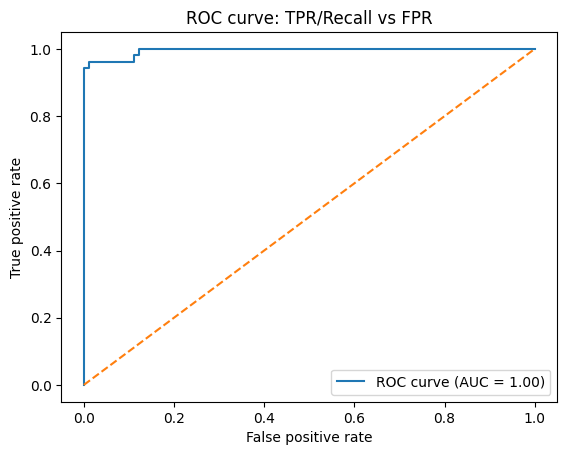

epoch 0: loss = 0.23658917449921552
epoch 10000: loss = 0.10022578180314397
epoch 20000: loss = 0.08118981874346214
epoch 30000: loss = 0.07356360417971702
epoch 40000: loss = 0.06923314114584901
epoch 50000: loss = 0.06626737630946337
epoch 60000: loss = 0.06403384465261998
epoch 70000: loss = 0.06226091314528144
epoch 80000: loss = 0.06080527778937977
epoch 90000: loss = 0.05958063358224447


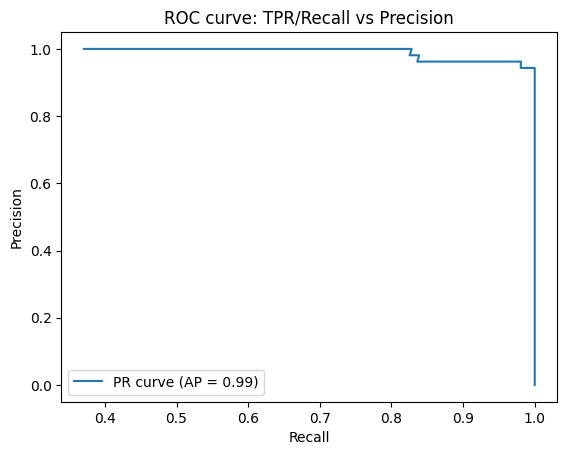

epoch 0: loss = 0.7305598740340586
epoch 10000: loss = 0.6995705283266423
epoch 20000: loss = 0.6887550869800151
epoch 30000: loss = 0.6808627458612092
epoch 40000: loss = 0.6750296614740269
epoch 50000: loss = 0.6706586420921785
epoch 60000: loss = 0.6673380412305322
epoch 70000: loss = 0.6647827202410235
epoch 80000: loss = 0.6627932037165242
epoch 90000: loss = 0.6612281327964912


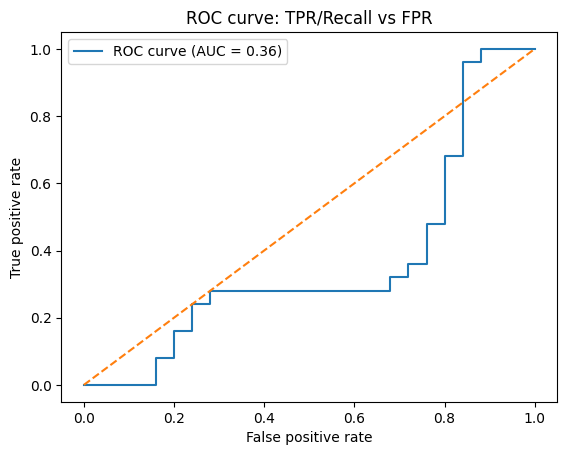

epoch 0: loss = 0.9480545405958702
epoch 10000: loss = 0.5918524446624521
epoch 20000: loss = 0.583118545471253
epoch 30000: loss = 0.576842441032134
epoch 40000: loss = 0.5723039733877698
epoch 50000: loss = 0.5689942453882648
epoch 60000: loss = 0.5665544365247444
epoch 70000: loss = 0.5647336219416833
epoch 80000: loss = 0.5633566917868508
epoch 90000: loss = 0.5623011842182806


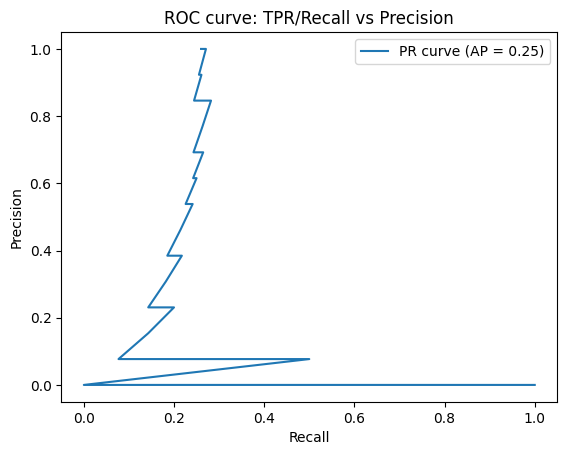

In [170]:
auc_roc(real=True, balanced=True)
auc_roc(real=True, balanced=False)
auc_roc(real=False, balanced=True)
auc_roc(real=False, balanced=False)